<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Coauthor-network" data-toc-modified-id="Coauthor-network-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Coauthor network</a></span></li><li><span><a href="#DBLP" data-toc-modified-id="DBLP-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>DBLP</a></span></li><li><span><a href="#CiteSeer" data-toc-modified-id="CiteSeer-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>CiteSeer</a></span></li><li><span><a href="#author-names-and-duplicates" data-toc-modified-id="author-names-and-duplicates-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>author names and duplicates</a></span></li><li><span><a href="#ground-truth-availability-filtering" data-toc-modified-id="ground-truth-availability-filtering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>ground truth availability filtering</a></span></li><li><span><a href="#Graphs" data-toc-modified-id="Graphs-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Graphs</a></span></li><li><span><a href="#Repairs" data-toc-modified-id="Repairs-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Repairs</a></span></li><li><span><a href="#Generate-repairs" data-toc-modified-id="Generate-repairs-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Generate repairs</a></span></li></ul></div>

# Coauthor network

We work with html dumps corresponding to Lei Chen's publications from CiteSeer (https://citeseerx.ist.psu.edu/) and DBLP (https://dblp.uni-trier.de/db/).

We construct a coauthor network from each dump, with a vertex for each (paper,author) pair labelled with auhor name, and edges between coauthors. The two coauthor networks will differ as CiteSeer does not disambiguate authors depending on their affiliation, while DBLP does.

The task is to use the DBLP graph as the constraint graph (in fact GT here) to relabel all mentions of "Lei Chen" in the instance CiteSeer graph, effectively acheiving disambiguation on success.

In [4]:
import os
import pandas as pd
import networkx as nx
import numpy as np
from igr import *

In [5]:
from bs4 import BeautifulSoup

In [6]:
prefix = "data/coauthor/"
files = os.listdir(prefix)


# DBLP

**Note:** Each file has the results for a distinguished "Lei Chen", e.g. Lei Chen HK-university $\neq$ Lei Chen Purdue University 

In [7]:
dblp_files = [f for f in files if "dblp" in f]
dblp_files

['dblp  Lei Chen 0002.htm',
 'dblp  Lei Chen 0003.htm',
 'dblp  Lei Chen 0004.htm',
 'dblp  Lei Chen 0005.htm',
 'dblp  Lei Chen.htm']

In [8]:
with open(prefix + dblp_files[0]) as f:
    soup = BeautifulSoup(f, 'html.parser')

print(soup.prettify())

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   dblp: Lei Chen 0002
  </title>
  <link href="http://www.informatik.uni-trier.de/~ley/img/favicon.ico" id="favicon" rel="shortcut icon"/>
  <link href="http://www.informatik.uni-trier.de/~ley/css/dblp20130605.css" rel="stylesheet" type="text/css"/>
  <!--[if IE 8]><link rel="stylesheet" href="http://www.informatik.uni-trier.de/~ley/css/dblp-ie8-fix.css" /><script src="http://www.informatik.uni-trier.de/~ley/js/html5.js"></script><![endif]-->
  <link href="http://fonts.googleapis.com/css?family=Open+Sans:300,400,600,700,800,subset=latin,cyrillic-ext,greek-ext,cyrillic,greek,latin-ext,vietnamese" rel="stylesheet" type="text/css"/>
  <link href="http://www.informatik.uni-trier.de/~ley/pers/xs/c/Chen_0002:Lei" rel="alternate" title="author page RSS feed" type="application/rss+xml"/>
 </head>
 <body class="no-js">
  <script>
   var el = document.getElementsByTagName("body")[0];el.className = "js";
  </script>
  <

In [9]:
mydivs = soup.find_all("div", {"class": "data"})
len(mydivs)

218

In [10]:
div = mydivs[120]
div

<div class="data"><a href="../../../pers/hd/z/Zhou:Xiangmin.html">Xiangmin Zhou</a>, <a href="../../../pers/hd/z/Zhou:Xiaofang.html">Xiaofang Zhou</a>, <span class="this-person">Lei Chen</span>, <a href="../../../pers/hd/b/Bouguettaya:Athman.html">Athman Bouguettaya</a>, <a href="../../../pers/hd/x/Xiao:Nong.html">Nong Xiao</a>, <a href="../../../pers/hd/t/Taylor:John_A=.html">John A. Taylor</a>: <span class="title">An Efficient Near-Duplicate Video Shot Detection Method Using Shot-Based Interest Points.</span> <a href="../../../db/journals/tmm/tmm11.html#ZhouZCBXT09">IEEE Transactions on Multimedia 11</a>(5): 879-891 (2009)</div>

In [11]:
def dblp_authors(data_div):
    """ returns all coauthors of Lei Chen"""
    return [link.get_text() for link in data_div.find_all("a")][:-1]

# after the DBLP search for Lei Chen, he does not show in the authors
# the correct label comes from the file name
["Lei Chen " + str(0)] + dblp_authors(div)

['Lei Chen 0',
 'Xiangmin Zhou',
 'Xiaofang Zhou',
 'Athman Bouguettaya',
 'Nong Xiao',
 'John A. Taylor']

In [12]:
coauthors = [dblp_authors(d) for d in mydivs]
all_authors = set(np.concatenate(coauthors))
len(all_authors)

200

In [13]:
dblp_coauthors = []
for i, file in enumerate(dblp_files):
    with open(prefix + file) as f:
        soup = BeautifulSoup(f, 'html.parser')
        mydivs = soup.find_all("div", {"class": "data"})
        for d in mydivs:
            coauthors = ["Lei Chen " + str(i)] + dblp_authors(d)
            dblp_coauthors.append(coauthors)
        
dblp_all_authors = set(np.concatenate(dblp_coauthors))
# we add a plain version of "lei Chen", which is the dummy from CiteSeer that we want to relabel
dblp_all_authors.add("Lei Chen")

# CiteSeer

In [14]:
citeseer_files = [f for f in files if "CiteSeerX" in f]
citeseer_files[:5]

['CiteSeerX lei chen 1.htm',
 'CiteSeerX lei chen 101.htm',
 'CiteSeerX lei chen 11.htm',
 'CiteSeerX lei chen 111.htm',
 'CiteSeerX lei chen 121.htm']

In [15]:
with open(prefix + citeseer_files[0]) as f:
    soup = BeautifulSoup(f, 'html.parser')

myspans = soup.find_all("span", {"class": "authors"})
print(len(myspans))
myspans[0]

10


<span class="authors">by 
                  Lei Chen, M. Tamer Özsu
                  
                </span>

In [16]:
coauthors = [s.get_text()[2:].split(",") for s in myspans]
coauthors = [[ a.strip() for a in authors] for authors in coauthors]
coauthors

[['Lei Chen', 'M. Tamer Özsu'],
 ['Fei Li', 'Deming Chen', 'Lei He', 'Jason Cong'],
 ['Lei Guo', 'Songqing Chen', 'Enhua Tan', 'Xiaoning Ding', 'Xiaodong Zhang'],
 ['Lei Chen', 'Raymond Ng'],
 ['Lei Chen', 'Student Member', 'Wendi B. Heinzelman'],
 ['Kuan-ta Chen', 'Polly Huang', 'Chun-ying Huang', 'Chin-laung Lei'],
 ['Lei Zhang', 'Longbin Chen', 'Mingjing Li', 'Hongjiang Zhang'],
 ['Benyu Zhang',
  'Hua Li',
  'Yi Liu',
  'Lei Ji',
  'Wensi Xi',
  'Weiguo Fan',
  'Zheng Chen',
  'Wei-ying Ma'],
 ['Xiang Lian', 'Lei Chen'],
 ['Guang-Bin Huang', 'Lei Chen', 'Chee-Kheong Siew']]

In [17]:
def citeseer_authors(span):
    authors = span.get_text()[2:].split(",")
    authors = [a.strip() for a in authors]
    return authors

coauthors = [citeseer_authors(s) for s in myspans]
coauthors

[['Lei Chen', 'M. Tamer Özsu'],
 ['Fei Li', 'Deming Chen', 'Lei He', 'Jason Cong'],
 ['Lei Guo', 'Songqing Chen', 'Enhua Tan', 'Xiaoning Ding', 'Xiaodong Zhang'],
 ['Lei Chen', 'Raymond Ng'],
 ['Lei Chen', 'Student Member', 'Wendi B. Heinzelman'],
 ['Kuan-ta Chen', 'Polly Huang', 'Chun-ying Huang', 'Chin-laung Lei'],
 ['Lei Zhang', 'Longbin Chen', 'Mingjing Li', 'Hongjiang Zhang'],
 ['Benyu Zhang',
  'Hua Li',
  'Yi Liu',
  'Lei Ji',
  'Wensi Xi',
  'Weiguo Fan',
  'Zheng Chen',
  'Wei-ying Ma'],
 ['Xiang Lian', 'Lei Chen'],
 ['Guang-Bin Huang', 'Lei Chen', 'Chee-Kheong Siew']]

In [18]:
cs_coauthors = []
for file in citeseer_files:
    with open(prefix + file) as f:
        soup = BeautifulSoup(f, 'html.parser')
        mydivs = soup.find_all("span", {"class": "authors"})
        len(mydivs)
        [cs_coauthors.append(citeseer_authors(d)) for d in mydivs]
        
cs_all_authors = set([a for authors in cs_coauthors for a in authors])

In [19]:
len(cs_all_authors)

2407

# author names and duplicates

In [20]:
len(cs_all_authors)

2407

In [21]:
len(dblp_all_authors)

688

In [22]:
list(cs_all_authors)[:10]

['P. Hoang',
 'Geoffrey R. Deschenes',
 'Xiaocheng Zhou',
 'Erika Lindquist',
 'F. Fred Samadani',
 'Paul Barford',
 'S. -k. Chen',
 'Suhua Zhang',
 'Er Chen',
 'Caleb Chen']

In [23]:
list(dblp_all_authors)[:10]

['Lulu Zheng',
 'Matthias Renz',
 'Kshirasagar Naik',
 'Allen Luo',
 'Bee-Chung Chen',
 'Paul Barford',
 'Jeffrey Rzeszotarski',
 'Ju Liu',
 'Sasu Tarkoma',
 'Congying Xu']

In [24]:
np.sort(list(cs_all_authors))[:100]

array(['A Mouse-adapted', 'A Tao Lei', 'A Wenqian Chen', 'A Yahong Li A',
       'A Yanmei Chen', 'A-ji Huang', 'A. Buonanno', 'A. C. Searle',
       'A. Chandler', 'A. Danielle Iuliano', 'A. Freise', 'A. Gillespie',
       'A. Hartunian', 'A. Ivanov', 'A. K. C. Wong', 'A. Lazzarini',
       'A. M. Sintes', 'A. Marin', 'A. Rüdiger', 'A. Takamori',
       'A. W. -c. Fu', 'A. Weidner', 'Aaron G Young', 'Aaron J. Bonham',
       'Abdul Rahman', 'Abhilash O Usharraj', 'Ada Wai-chee',
       'Ada Wai-chee Fu', 'Address Space Layout R', 'Adel Ben Mnaouer',
       'Agathe Bourgogne', 'Agnieszka Szynol', 'Ahmad Yamin', 'Ai Qi Di',
       'Ai-hua Lin', 'Ai-ling Chen', 'Ailong Huang',
       'Airway Epithelial Cells', 'Ajith Abraham', 'Akumar Jayasekaran',
       'Alan S. Willsky', 'Alan S. Willsky A', 'Albert Rizzo',
       'Alex Santos', 'Alex Shye', 'Alexander T. Ihler',
       'Alfred Mateczun', 'Alfred Mertins', 'Almira S. Punjabi',
       'Amy Franklin', 'An Liang', 'An-an Jiang', 'Anan Ji

In [25]:
np.sort(list(dblp_all_authors))[:100]

array(['Ada Wai-Chee Fu', 'Adel Ben Mnaouer', 'Ah Chung Tsoi',
       'Alan S. Willsky', 'Alexander Vießmann', 'Alfred Mertins',
       'Ali Ghaffari', 'Allen Luo', 'Amy Franklin', 'Andrea Pellegrini',
       'Andreas Züfle', 'Andrew H. Sung', 'Andrew J. Kalafut',
       'Anguel Nikolov', 'Anna M. Ritz', 'Antonio Capone',
       'Arkan Al-Zubaidi', 'Armin Eberlein', 'Athman Bouguettaya',
       'Balaji Raghavachari', 'Bao-Hua Zhao', 'Baoqing Dong',
       'Barry J. Weinbaum', 'Bart M. ter Haar Romeny', 'Bee-Chung Chen',
       'Benjamin J. Anderson', 'Bihuan Xu', 'Bin Wang', 'Bin Wu', 'Bo Ye',
       'Boleslaw K. Szymanski', 'Bolin Ding', 'Bonghee Hong',
       'Caleb Chen Cao', 'Catherine Nelson', 'Chang-Kye Lee',
       'Changhong Lu', 'Changjie Tang', 'Changliang Wang',
       'Changxuan Wan', 'Changzhi Li', 'Chao Wang', 'Chee Kheong Siew',
       'Chen Jason Zhang', 'Cheng-I. Chu', 'Chengfei Liu', 'Cheqing Jin',
       'Chi Zhang', 'Ching Yu Liao', 'Ching-Hsien Hsu', 'Chinmaya Mish

In [26]:
np.sort([l for l in list(dblp_all_authors) if "Lei" in l])[:100]

array(['Lei Chen', 'Lei Chen 0', 'Lei Chen 1', 'Lei Chen 2', 'Lei Chen 3',
       'Lei Chen 4', 'Lei Kang', 'Lei Wang', 'Lei Xu', 'Lei Zhang',
       'Lei Zou'], dtype='<U10')

In [27]:
np.sort([l for l in list(cs_all_authors) if "Lei" in l])[:100]

array(['A Tao Lei', 'Anping Lei', 'Chen Lei', 'Chi-un Lei',
       'Chin-laung Lei', 'Chin-laung Lei A', 'Chuzhao Lei',
       'Chuzhao Lei A', 'Dongliang Lei', 'Fu Lei', 'Gao Lei', 'H. Lei',
       'Hai Lei Zhang', 'Hong Lei', 'Hong-bo Lei', 'Hongtao Lei',
       'Huali Lei', 'Huan-yao Lei', 'Huaping Lei', 'Hui-chieh Lei',
       'Ji Lei', 'Jing Lei He', 'Jinzhi Lei', 'Jun Chen Lei',
       'Ke-jian Lei', 'Ke-wei Lei B', 'Lei An', 'Lei Ba', 'Lei Bao',
       'Lei Cai', 'Lei Cao', 'Lei Chang', 'Lei Chen', 'Lei Chen A',
       'Lei Chen Zhi-hua Zhou', 'Lei Cheng', 'Lei Cheng Deming Chen',
       'Lei Cui', 'Lei Ding', 'Lei Du', 'Lei Duan', 'Lei Fan', 'Lei Fang',
       'Lei Fu', 'Lei Gao', 'Lei Guo', 'Lei He', 'Lei Hengchi', 'Lei Hu',
       'Lei Huang', 'Lei Ji', 'Lei Jiang', 'Lei Jiao', 'Lei Jimmy Ba',
       'Lei Jing', 'Lei Kang', 'Lei L. Chen', 'Lei Lei', 'Lei Li',
       'Lei Liang', 'Lei Liu', 'Lei Lou', 'Lei Lu', 'Lei Lv', 'Lei Ma',
       'Lei Pan', 'Lei Qin C', 'Lei Qing', 'Le

In [28]:
len(cs_all_authors.intersection(dblp_all_authors))

152

# ground truth availability filtering

We will work with a tractable subset of the instance graph, for which we have ground truth. Namely, we need a coauthor connected component from DBLP that is similar to an instance connected component (CiteSeer). I.e. we have the ground turth for this coauthorship.

We filter the instance graph to respect this need.

In [29]:
# only papers with full intersection with dblp all authors
tractable = []
for coauthor in cs_coauthors:
    if len(coauthor) == len(set(coauthor).intersection(dblp_all_authors)):
        tractable.append(coauthor)

print(len(tractable))
tractable[:10]

74


[['Lei Chen', 'M. Tamer Özsu'],
 ['Xiang Lian', 'Lei Chen'],
 ['Lei Chen'],
 ['Wenwei Xue', 'Qiong Luo', 'Lei Chen', 'Yunhao Liu'],
 ['Lei Zou', 'Lei Chen', 'M. Tamer Özsu'],
 ['Xiang Lian', 'Lei Chen'],
 ['Lei Chen', 'M. Tamer Özsu', 'Vincent Oria'],
 ['Xiang Lian', 'Lei Chen'],
 ['Shaoxu Song', 'Lei Chen', 'Philip S. Yu'],
 ['Lei Chen']]

In [30]:
tractable[3]

['Wenwei Xue', 'Qiong Luo', 'Lei Chen', 'Yunhao Liu']

In [31]:
# given a citeseer coauthorship, find at least a similar coauthorship in dblp
def similar_coauthors(citeseer_coauthor, dblp_coauthors):
    
    for coauthor in dblp_coauthors:
        if len(citeseer_coauthor) == len(coauthor):
            similar = all([a in coauthor for a in citeseer_coauthor if a != "Lei Chen"])
            if similar:
                return coauthor
    return False

print("citeseer: ", tractable[3], "\ndblp    : ", similar_coauthors(tractable[3], dblp_coauthors))

dblp_tractable = [similar_coauthors(t, dblp_coauthors) for t in tractable]
print("all tractable have a similar entry in dblp: ", all(dblp_tractable))

# Filter based on gt avalability
instance = [tractable[i] for i in range(len(tractable)) if dblp_tractable[i] != False]
gt = [d for d in dblp_tractable if d != False]
print("lost tractable coauthorships:", len(tractable) - len(instance))

citeseer:  ['Wenwei Xue', 'Qiong Luo', 'Lei Chen', 'Yunhao Liu'] 
dblp    :  ['Lei Chen 0', 'Wenwei Xue', 'Qiong Luo', 'Yunhao Liu']
all tractable have a similar entry in dblp:  False
lost tractable coauthorships: 3


# Graphs

**Note**: 
- In G: a fully connected component per paper, with a "Lei Chen"
- in S: a fully connected component per paper, with a "Lei Chen X" + an isolated "Lei Chen"

Repair: replace "Lei Chen" by "Lei Chen X"


TODO remove head :20 in graph generation

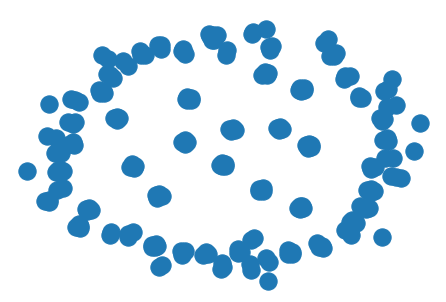

In [32]:
G = nx.Graph()
i = 0
for i,coauthor in enumerate(instance):
    
    for j,a in enumerate(coauthor):
        G.add_node(i * 1000 + j)
        G.nodes[i*1000 + j]['label'] = a
    
    edges = [(i*1000 + a, i*1000 + b) for a in range(len(coauthor)) 
                                      for b in range(len(coauthor)) if a != b]
    G.add_edges_from(edges)
    
nx.draw(G)

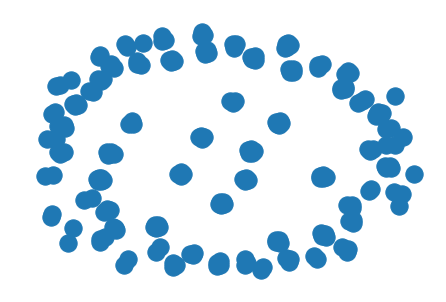

In [33]:
G_opt = nx.Graph()
i = 0
for i,coauthor in enumerate(gt):
    
    for j,a in enumerate(coauthor):
        G_opt.add_node(i * 1000 + j)
        G_opt.nodes[i*1000 + j]['label'] = a
    
    edges = [(i*1000 + a, i*1000 + b) for a in range(len(coauthor)) 
                                      for b in range(len(coauthor)) if a != b]
    G_opt.add_edges_from(edges)
    
nx.draw(G_opt)

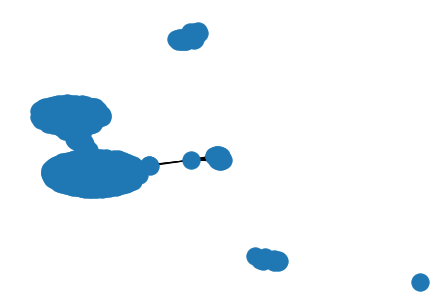

In [34]:
S = nx.Graph()
S.add_nodes_from(dblp_all_authors)
for coauthor in dblp_coauthors:
    S.add_edges_from([(a, b) for a in coauthor for b in coauthor if (a != b)])
    
nx.draw(S)

In [35]:
list(S.neighbors("Lei Chen 3"))

['Zijian Wang',
 'Boleslaw K. Szymanski',
 'Joel W. Branch',
 'Dinesh C. Verma',
 'Raju Damarla',
 'John Ibbotson',
 'Nenggan Zheng',
 'Zhaohui Wu',
 'Yanmiao Zhou',
 'Qijia Wang']

141


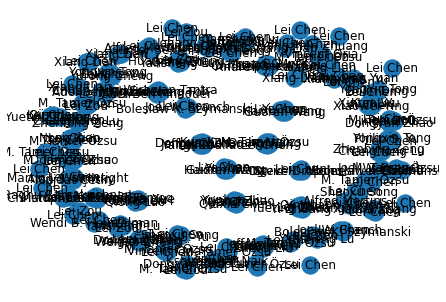

In [36]:
print(len(violations(G,S)))
draw_G(G,S)

In [37]:
print( "|V| = ", len(G_opt.nodes))
print("|E|/|V| =", len(G_opt.edges) / len(G_opt.nodes))
print( "|L| = ", len(S.nodes))
print("|N|/|L| =", len(S.edges) / len(S.nodes))

|V| =  212
|E|/|V| = 1.2358490566037736
|L| =  688
|N|/|L| = 3.3299418604651163


# Repairs

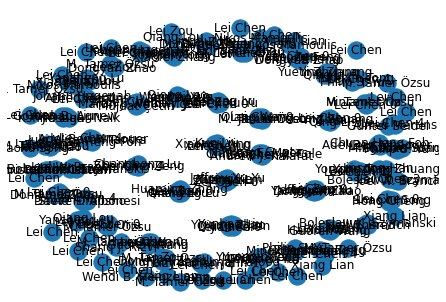

In [38]:
R = repair(G.copy(), S)
draw_G(R,S)

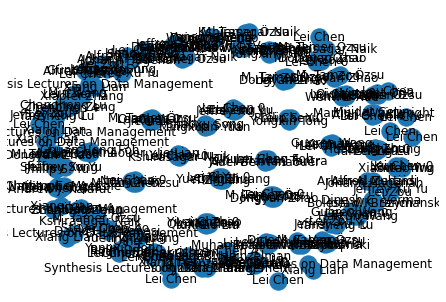

In [39]:
draw_G(UserRepair(G.copy(), S, userGreedy, *f_perm), S)

# Generate repairs 

In [40]:
x = []
for noise in [(0.08, 0.12), (0.18, 0.22), (0.27,0.33)]:
    for i in range(20):
        
        #inject noise
        G = force_inject_violations(G_opt, S, *noise)
        
        #generate repairs
        df = generate_all_repairs(G_opt, S, G, repair(G.copy(),S), steps = len(G.nodes)*2)
        df["noise"] = str(noise)
        
        x.append(df.copy())
        
df = pd.concat(x)

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(zip(df.columns, [G,S,G_opt,R, None, None, None, f, u])), ignore_index=True)
/mnt/c/Users/paul/Documents/LIRIS/code/igr.py:572: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

In [41]:
df

,G,S,G_opt,R,G',Answers,Q_difficulty,framework,user,noise
0,"(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(Lulu Zheng, Matthias Renz, Kshirasagar Naik, ...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","[yes, no, no, no, no, yes, yes, yes, no, no, y...","[(4, 2), (4, 2), (4, 2), (4, 2), (4, 2), (4, 2...",bool,userRandom,"(0.08, 0.12)"
1,"(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(Lulu Zheng, Matthias Renz, Kshirasagar Naik, ...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","[(30001, Yueting Zhuang), (31000, Qiang Wang),...","[(2, 14), (2, 8), (2, 8), (2, 30), (2, 30), (2...",gree,userRandom,"(0.08, 0.12)"
2,"(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(Lulu Zheng, Matthias Renz, Kshirasagar Naik, ...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...",None,"[(30002, Tuanjie Zhao), (30004, Jian-de Zhang)...","[(2, 1377), (2, 1377), (2, 1377), (2, 1377), (...",perm,userRandom,"(0.08, 0.12)"
3,"(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(Lulu Zheng, Matthias Renz, Kshirasagar Naik, ...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","[(30001, Yi Zhuang), (31000, Jyh-haw Yeh), (31...","[(2, 6), (2, 7), (2, 5), (2, 5), (2, 201), (2,...",term,userRandom,"(0.08, 0.12)"
4,"(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(Lulu Zheng, Matthias Renz, Kshirasagar Naik, ...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...",None,"[delete, yes, yes, yes, yes, delete, delete, y...","[(4, 2), (4, 2), (4, 2), (4, 2), (4, 2), (4, 2...",bool,userGreedy,"(0.08, 0.12)"
...,...,...,...,...,...,...,...,...,...,...
7,"(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(Lulu Zheng, Matthias Renz, Kshirasagar Naik, ...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","[(30004, Clarence A. Ellis), (31000, Qiang Wan...","[(2, 17), (2, 11), (2, 5), (2, 5), (2, 16), (2...",term,userGreedy,"(0.27, 0.33)"
8,"(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(Lulu Zheng, Matthias Renz, Kshirasagar Naik, ...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","[no, yes, yes, no, no, no, yes, no, yes, no, y...","[(4, 2), (4, 2), (4, 2), (4, 2), (4, 2), (4, 2...",bool,userOracle,"(0.27, 0.33)"
9,"(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(Lulu Zheng, Matthias Renz, Kshirasagar Naik, ...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","[(30002, Lei Chen 4), (31000, Lei Chen 0), (31...","[(2, 11), (2, 24), (2, 25), (2, 19), (2, 7), (...",gree,userOracle,"(0.27, 0.33)"
10,"(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(Lulu Zheng, Matthias Renz, Kshirasagar Naik, ...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","(0, 1, 1000, 1001, 2000, 3000, 3001, 3002, 300...","[(30004, Yi Yu), (31000, Lei Chen 0), (31001, ...","[(2, 1377), (2, 1377), (2, 1377), (2, 1377), (...",perm,userOracle,"(0.27, 0.33)"


In [42]:
df.to_pickle("temp/coauthor_repairs.pickle")